 #  <center> Modèles de prédiction des propriétés des matériaux (ANN - XGBoost)</center>


## 1- Importation des librairies

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from ase import Atoms
import warnings
from scipy.sparse import load_npz
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from ase.build import molecule
import time
from pymatgen.ext.matproj import MPRester
import seaborn as sns
import pandas as pd
import scipy.io
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from pymatgen.io.cif import CifParser
from sklearn.svm import SVC
from dscribe.descriptors import CoulombMatrix
import keras
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
import numpy, math, random
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from mpl_toolkits.mplot3d import Axes3D
from keras.layers import Dense, Conv1D, Flatten

warnings.simplefilter('ignore')

rand_state = 42 
np.random.seed(rand_state)
tf.random.set_seed(rand_state)

## 2- Caractérisation des matériaux en utilisant les matrices de Coulomb

In [4]:
# utilisation de la librairie Atoms pour caractériser les matériaux
atoms = np.load("atoms.npy", allow_pickle=True) 

In [38]:
# Calcul de la matrice de Coulomb
Nel_max = max([len(at.get_positions()) for at in atoms])
cm = CoulombMatrix(n_atoms_max=Nel_max, flatten=False, permutation='eigenspectrum')
CMs = []
for atom in atoms:
    CMs.append(cm.create(atom))

CMs = np.array(CMs)

 CMs correspondra à la matrice dont chaque ligne représente un matériau et contient la liste triée des valeurs propres de sa matrice de Coulomb

In [13]:
# taille de la matrice CMs
print('La taille de la matrice CMs est', np.shape(CMs))

La taille de la matrice CMs est (47743, 432)


In [14]:
print(CMs[0])

[983.33361811 301.88315232 174.54181395 174.54181395   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         

In [15]:
# Importation des énergies de formation
data = pd.read_csv('Materials_ene_real.csv', index_col=0)
energie = data['formation_energy_per_atom'] # contient l'identifiant du matériau ainsi que son énergie de formation


In [16]:
print(energie)

material_id
mp-1008554   -0.150653
mp-1008555   -0.181494
mp-1008753    0.572197
mp-1014462    0.086249
mp-1018101   -0.132060
                ...   
mvc-16628    -1.440505
mvc-16728    -1.503079
mvc-16741    -1.770293
mvc-16790    -1.952872
mvc-7054     -1.487992
Name: formation_energy_per_atom, Length: 47743, dtype: float64


In [17]:
# On élimine la première colone qui contient les identifiants 
EF = np.array([]) 
for i in range(47743):
    EF = np.append(EF,energie[i])

In [18]:
# taille de la liste EF
print('La taille de la liste EF est', len(EF))

La taille de la liste EF est 47743


In [19]:
print(EF)

[-0.15065287 -0.18149385  0.57219714 ... -1.77029296 -1.95287209
 -1.48799245]


##  3- Modèles de prédiction

###  3.1- Premier modèle : Artificial Neural Network (ANN) en utilisant la classe MLP

### $\color{blue}{\text{On considère un modèle avec 5000 matériaux en entrée et on consacre 30% pour le test}}$

In [67]:
CMs_train, CMs_test, EF_train, EF_test = train_test_split(CMs[:5000], EF[:5000] , test_size=0.3, random_state=rand_state)

In [35]:
# setup du réseau de neurones
nn = MLPRegressor(hidden_layer_sizes=(1000,200,50,50),  activation='tanh', solver='lbfgs', alpha=0.01, 
                  learning_rate='adaptive')

In [73]:
nn.set_params(solver='lbfgs')

nn.fit(CMs_train, EF_train); 

Mean Abs Error (training)  :  0.38400889784169834
Mean Abs Error (validation):  0.6296009470904539


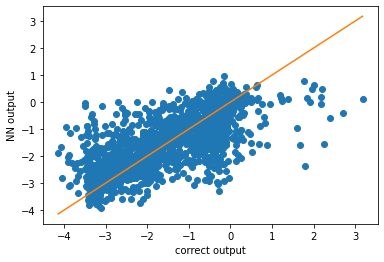

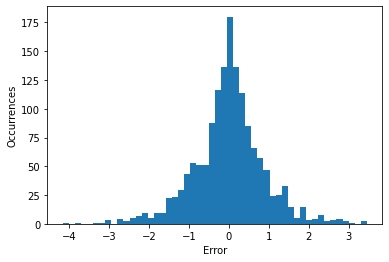

In [74]:
# evaluation de l'erreur de training et de validation
EF_ML_train = nn.predict(CMs_train)
EF_ML_test = nn.predict(CMs_test)

print ("Mean Abs Error (training)  : ", (numpy.abs(EF_ML_train-EF_train)).mean())
print ("Mean Abs Error (validation): ", (numpy.abs(EF_ML_test-EF_test)).mean())

plt.plot(EF_test,EF_ML_test,'o')
plt.plot([min(EF_test),max(EF_test)],[min(EF_test),max(EF_test)]) # perfect fit line
plt.xlabel('correct output')
plt.ylabel('NN output')
plt.show()

# error histogram
plt.hist(EF_ML_test-EF_test,50)
plt.xlabel("Error")
plt.ylabel("Occurrences")
plt.show()

###  3.1- Deuxième modèle :  XGBoost

### $\color{blue}{\text{On commence d'abord par un modèle avec 5000 entrées et on consacre 15% pour le test }}$

In [20]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
# setup du modèle
X_2, X_val, y_2, y_val = train_test_split(CMs[:5000], EF[:5000],  # 5000 entrées
                                          test_size=0.15, 
                                          random_state=rand_state)
X_train, X_dev, y_train, y_dev = train_test_split(X_2, y_2, 
                                                  test_size=0.18, 
                                                  random_state=rand_state)

In [41]:
n_folds = 5
early_stopping = 50


start_time = time.time()
xg_train = xgb.DMatrix(X_train, label=y_train)

num_iters = 300

In [42]:
params = {"objective":"reg:linear", 
          'booster': 'gbtree', 
          'eval_metric': 'mae',
          'subsample': 0.9,
          'colsample_bytree':0.2,
          'learning_rate': 0.05,
          'max_depth': 6, 
          'reg_lambda': .9, 
          'reg_alpha': .01,
          'seed': rand_state}

[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[00:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
--- 61.155675411224365 seconds ---


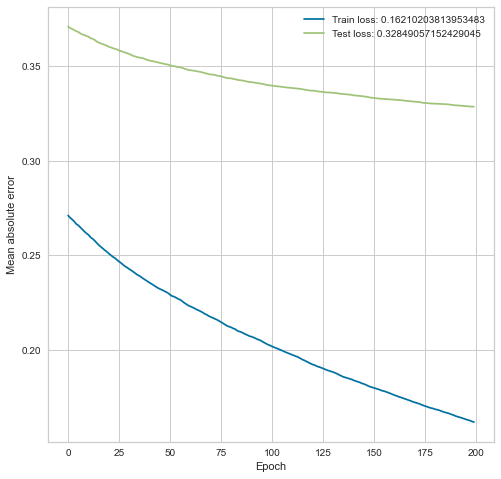

[00:01:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
Dev mean absolute error:  0.29181849961211037
Validation mean absolute error:  0.334664080367086


In [46]:
cv = xgb.cv(params,
            xg_train, 
            num_boost_round=num_iters, 
            nfold=n_folds, 
            early_stopping_rounds=early_stopping, 
            verbose_eval = 0, 
            seed=rand_state,
            as_pandas=False)

print("--- %s seconds ---" % (time.time() - start_time))

# courbe MAE
plt.figure(figsize=(8,8))
plt.plot(cv['train-mae-mean'][100:], label='Train loss: ' + str(np.min(cv['train-mae-mean'])))
plt.plot(cv['test-mae-mean'][100:], label='Test loss: ' + str(np.min(cv['test-mae-mean'])))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.show()


model_xgb = xgb.XGBRegressor(**params, random_state=rand_state, n_estimators=num_iters)
model_xgb.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping, 
               
              eval_set=[(X_dev, y_dev)], 
              verbose=False)

y_dev_pred = model_xgb.predict(X_dev)
print('Dev mean absolute error: ', mean_absolute_error(y_dev, y_dev_pred))

y_val_pred = model_xgb.predict(X_val)
print('Validation mean absolute error: ', mean_absolute_error(y_val, y_val_pred))

[00:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


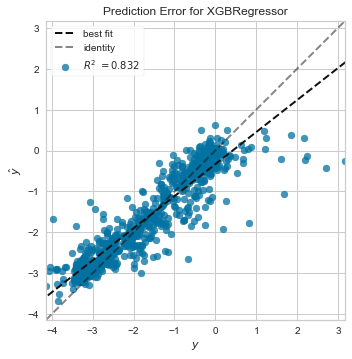

Validation mean absolute error:  0.334664080367086


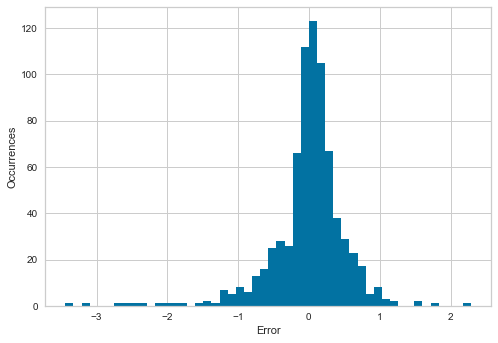

In [47]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
visualizer = PredictionError(xgb.XGBRegressor(**params, n_estimators=num_iters, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof() 
print('Validation mean absolute error: ', mean_absolute_error(y_val, y_val_pred))

# error histogram
plt.hist(y_val_pred-y_val,50)
plt.xlabel("Error")
plt.ylabel("Occurrences")
plt.show()

### $\color{red}{\text{Remarque :}}$ 
En comparant ce modèle de XGBoost au modèle des réseaux de neurones pour le même nombre de donnée en entrée (5000), on remarque que la prédiction en utilisant le XGBoost est beaucoup plus rapide et efficace avec une erreur moyenne de 0.33 tandis qu'en utilisant un réseaux de neurones on a obtenu une erreur de 0.63






### $\color{blue}{\text{On passe maintenant à un modèle utlisant toute la base de donnée comme entrée (47743 matériaux)}}$

In [28]:
X_2, X_val, y_2, y_val = train_test_split(CMs, EF,  # tous les matériaux
                                          test_size=0.15, 
                                          random_state=rand_state)
X_train, X_dev, y_train, y_dev = train_test_split(X_2, y_2, 
                                                  test_size=0.18, 
                                                  random_state=rand_state)

In [29]:
n_folds = 5
early_stopping = 50


start_time = time.time()
xg_train = xgb.DMatrix(X_train, label=y_train)

num_iters = 300

In [30]:
params = {"objective":"reg:linear", 
          'booster': 'gbtree', 
          'eval_metric': 'mae',
          'subsample': 0.9,
          'colsample_bytree':0.2,
          'learning_rate': 0.05,
          'max_depth': 6, 
          'reg_lambda': .9, 
          'reg_alpha': .01,
          'seed': rand_state}

[23:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
--- 87.90545058250427 seconds ---


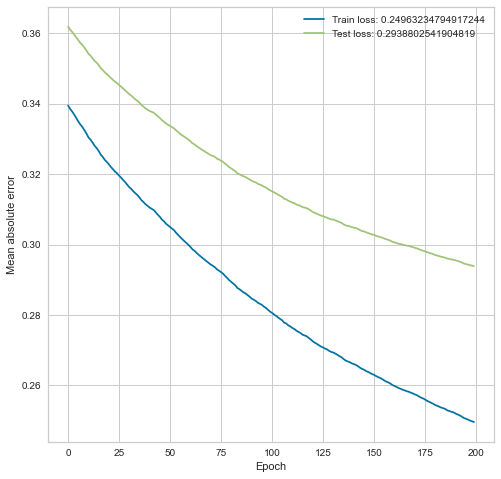

[23:38:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
Dev mean absolute error:  0.2927733127898795
Validation mean absolute error:  0.28879650323643036


In [31]:
cv = xgb.cv(params,
            xg_train, 
            num_boost_round=num_iters, 
            nfold=n_folds, 
            early_stopping_rounds=early_stopping, 
            verbose_eval = 0, 
            seed=rand_state,
            as_pandas=False)

print("--- %s seconds ---" % (time.time() - start_time))


plt.figure(figsize=(8,8))
plt.plot(cv['train-mae-mean'][100:], label='Train loss: ' + str(np.min(cv['train-mae-mean'])))
plt.plot(cv['test-mae-mean'][100:], label='Test loss: ' + str(np.min(cv['test-mae-mean'])))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.show()


model_xgb = xgb.XGBRegressor(**params, random_state=rand_state, n_estimators=num_iters)
model_xgb.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping, 
               
              eval_set=[(X_dev, y_dev)], 
              verbose=False)

y_dev_pred = model_xgb.predict(X_dev)
print('Dev mean absolute error: ', mean_absolute_error(y_dev, y_dev_pred))

y_val_pred = model_xgb.predict(X_val)
print('Validation mean absolute error: ', mean_absolute_error(y_val, y_val_pred))

[23:52:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


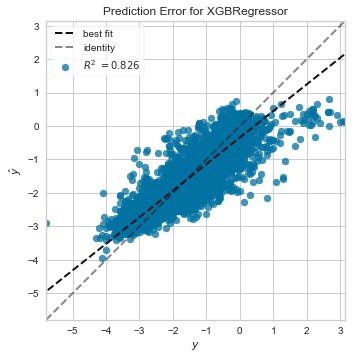

Validation mean absolute error:  0.28879650323643036


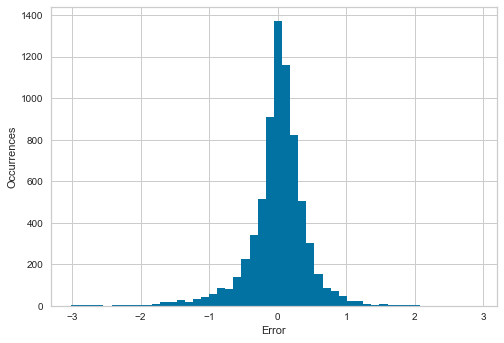

In [37]:
from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer
visualizer = PredictionError(xgb.XGBRegressor(**params, n_estimators=num_iters, random_state=rand_state))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof() 
print('Validation mean absolute error: ', mean_absolute_error(y_val, y_val_pred))

# error histogram
plt.hist(y_val_pred-y_val,50)
plt.xlabel("Error")
plt.ylabel("Occurrences")
plt.show()

### $\color{red}{\text{Remarque :}}$ 
On remarque que malgré le grand nombre de donnée en entrée, la durée de l'apprentissage est petite et la précision de prédiction s'est amélioré et l'erreur moyenne est maintenant 0.29